# TODO

1. [ ] Regression target variable big spike
2. [x] Stardard VS normalized??
3. [x] Stardard before XBG -> no use? -> yes, no use

# Module 

In [88]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import datasets
from xgboost.sklearn import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

from src.AssignmentTools.xgboost_tools import plot_feature_importances
from src.AssignmentTools.pca import plot_pca_res

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Config 

In [2]:
data = datasets.fetch_california_housing()

In [3]:
X = pd.DataFrame(data.data)
y = pd.DataFrame(data.target)
X.columns = data.feature_names

# EDA & Data Process

## Label 

In [16]:
y.describe()

,0
count,20640.000000
mean,2.068558
std,1.153956
min,0.149990
25%,1.196000
50%,1.797000
75%,2.647250
max,5.000010


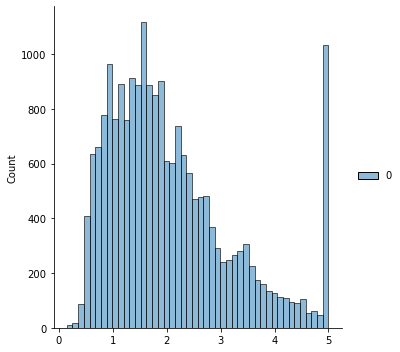

In [17]:
sns.displot(data=y, kind='hist')

## Features 

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [21]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [23]:
X.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [24]:
df = X
continuous_cols = X.columns

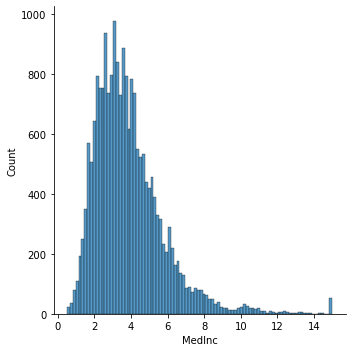

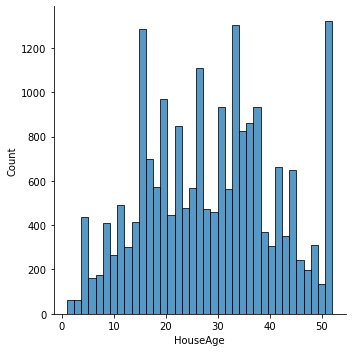

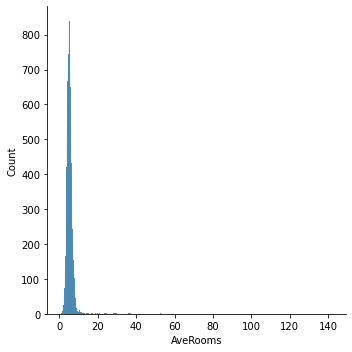

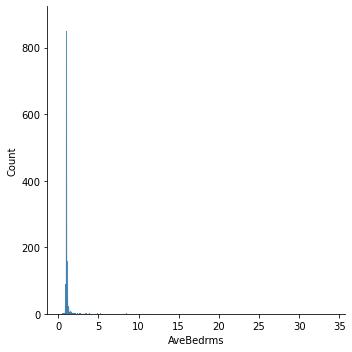

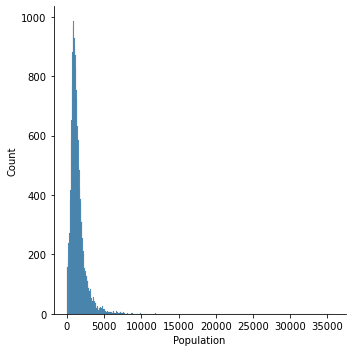

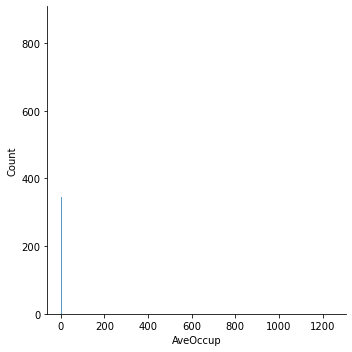

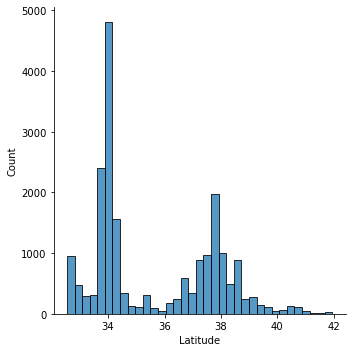

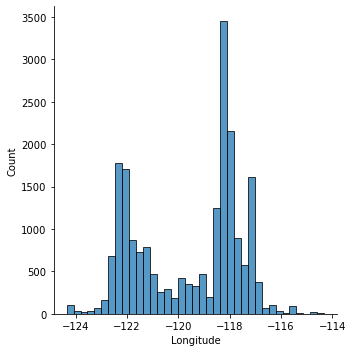

In [26]:
for col in continuous_cols:
    sns.displot(x=df[col])
#     plt.show()

## train test split 

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [9]:
print(f"train shape: {train_X.shape}")
print(f"test shape: {test_X.shape}")

train shape: (16512, 8)
test shape: (4128, 8)


In [11]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 1216 to 17588
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      16512 non-null  float64
 1   HouseAge    16512 non-null  float64
 2   AveRooms    16512 non-null  float64
 3   AveBedrms   16512 non-null  float64
 4   Population  16512 non-null  float64
 5   AveOccup    16512 non-null  float64
 6   Latitude    16512 non-null  float64
 7   Longitude   16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


# Linear Regression 

In [50]:
# encode_df = X
# pipeline_lst = []
# x_train, y_train  = train_X, train_y
# x_test, y_test = test_X, test_y

# mms = False

In [113]:
def experiment(encode_df = X, x_train=train_X, y_train=train_y, x_test=test_X, y_test=test_y, mms=False, pca=False, model_type='linear'
              , standard=False, cof=1, show_res=True):
    assert model_type in ['linear', 'lasso', 'ridge']
    pipeline_lst = []
    if pca:
#         comment_num = 5
        pca_scaler = PCA(n_components=7)
        pipeline_lst.append(
            ('pca', pca_scaler)
        )
    if standard:
        st_scaler = StandardScaler()
        encode_df = st_scaler.fit_transform(encode_df)
        pipeline_lst.append(
            ('st', st_scaler)
        )
    if mms:
        mms = MinMaxScaler(feature_range=[0, 1])
        encode_df = mms.fit_transform(encode_df)
        pipeline_lst.append(
            ('mms', mms)
        )
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'lasso':
        model = Lasso(alpha=cof)
    else:
        model = Ridge(alpha=cof)
    pipeline_lst.append(
        ('model', model)
    )
    pipeline = Pipeline(pipeline_lst)
    pipeline.fit(x_train, y_train)
    predicted_test = pipeline.predict(x_test)
    predicted_train = pipeline.predict(x_train)
    test_mse = round(mean_squared_error(y_pred=predicted_test, y_true=y_test), 5)
    train_mse = round(mean_squared_error(y_pred=predicted_train, y_true=y_train), 5)
    if show_res:
        print(f"train mse: {train_mse}; test mes: {test_mse}")
    return test_mse

In [93]:
experiment(mms=False)

train mse: 0.526; test mes: 0.52


In [94]:
experiment(mms=True)

train mse: 0.526; test mes: 0.52


In [111]:
experiment(mms=False, standard=True)

train mse: 0.52556; test mes: 0.51982


0.51982

In [124]:
experiment(mms=False, model_type='lasso')

train mse: 0.95254; test mes: 0.95957


0.95957

In [125]:
experiment(mms=True, model_type='lasso')

train mse: 1.32913; test mes: 1.34124


1.34124

In [126]:
experiment(mms=False, model_type='ridge')

train mse: 0.52556; test mes: 0.51983


0.51983

In [127]:
experiment(mms=True, model_type='ridge')

train mse: 0.53283; test mes: 0.52878


0.52878

In [100]:
experiment(mms=False, standard=True, model_type='ridge')

train mse: 0.526; test mes: 0.52


In [101]:
experiment(mms=False, standard=True, model_type='lasso')

train mse: 1.329; test mes: 1.341


In [72]:
experiment(pca=True)

train mse: 0.538; test mes: 0.534


In [73]:
experiment(pca=True, mms=True)

train mse: 0.538; test mes: 0.534


## Lasso & ridge 

In [130]:
candidates = [0.01*i for i in range(300)]
best_cof = None
current_mse = float('inf')
mse_lst = []
for cof in candidates:
    mse = experiment(cof=cof, mms=True, model_type='lasso', show_res=False)
    mse_lst.append(mse)
    if mse< current_mse:
        current_mse = mse
        best_cof = cof
print(f"{best_cof}; {current_mse}")

/Users/mac/.conda/envs/machine_learning_learning/lib/python3.6/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/mac/.conda/envs/machine_learning_learning/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/mac/.conda/envs/machine_learning_learning/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4338.98799200892, tolerance: 2.194655847172007
  positive)


0.0; 0.51982


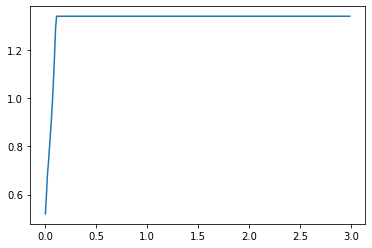

In [131]:
plt.plot(candidates, mse_lst)

# insight 

1. When applying linear regression, MinMaxScaler has no effects
2. When applying Lasso or Ridge, MinMaxScaler seems has negative effects
3. Ridge performed better than Lasso in this case; but ridge's performance is the same as linear regression
4. PCA has negative effect because the feature dimension are so rare

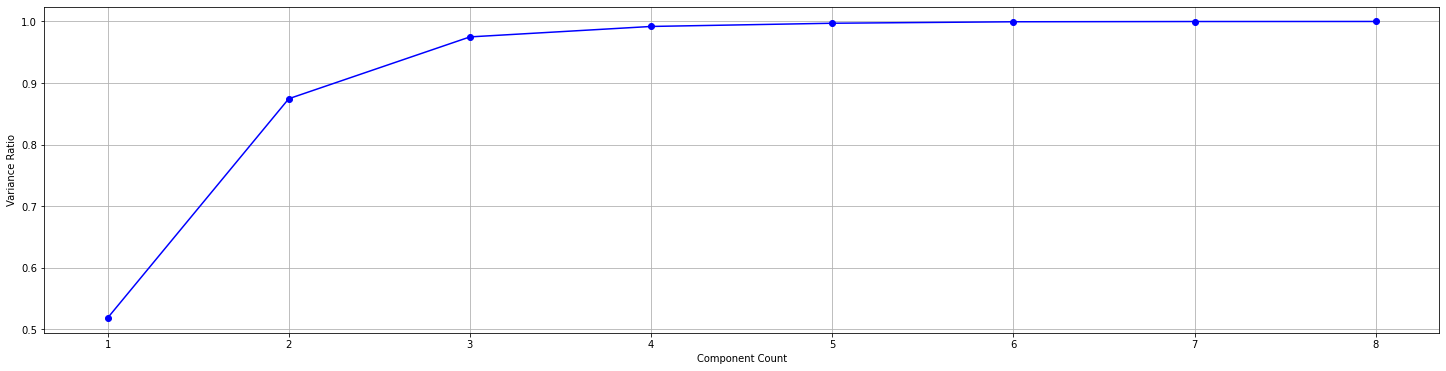

In [55]:
plot_pca_res(X)

# Model Training 

## Grid Search 

In [84]:
xgb = XGBRegressor()

parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [
                  .03, 
                  #0.05, .07, 0.1
              ],
              'max_depth': [ 9 ],
              'min_child_weight': [1],
              'silent': [1],
              'subsample': [ #0.8, 0.9, 
                  0.95],
              'colsample_bytree': [ 0.8, #0.9, 0.95
                                  ],
              'n_estimators': [
                              #100, 
                              # 200, 300, 
                  500
                  #600, 700, 800, 900
                              ]
}
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)
xgb_grid.fit(train_X,
         train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

params = xgb_grid.best_params_

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[19:42:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.8323104728853556
{'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.95}


## Model Evaluation With Cross Validation 

In [85]:
model = XGBRegressor(**params)
cv = RepeatedKFold(n_splits=10, n_repeats=3)
scores = cross_val_score(estimator=model, X=X, y=y, cv=cv)

[19:43:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:43:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:44:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/wor

[19:50:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:51:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:51:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/wor

In [86]:
print(f'Mean score: {np.mean(scores)}')

Mean score: 0.8556150180853205


## Model Training 

In [87]:
model = XGBRegressor(**params)
model.fit(train_X, train_y)


# pipe_lst = [model]

pipeline = make_pipeline(model)

# predict_test_y = pipeline.predict(test_X)
# predict_train_y = pipeline.predict(train_X)
# print(mean_squared_error(train_y, predict_train_y))
# print(mean_squared_error(test_y, predict_test_y))


[19:59:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(steps=[('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.8, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.03,
                              max_delta_step=0, max_depth=9, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=4, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, silent=1, subsample=0.95,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [99]:
predicted_test = pipeline.predict(x_test)
predicted_train = pipeline.predict(x_train)
test_mse = round(mean_squared_error(y_pred=predicted_test, y_true=y_test), 3)
train_mse = round(mean_squared_error(y_pred=predicted_train, y_true=y_train), 3)

print(f"train mse: {train_mse}; test mes: {test_mse}")

train mse: 0.026; test mes: 0.186


## Feature Importance 

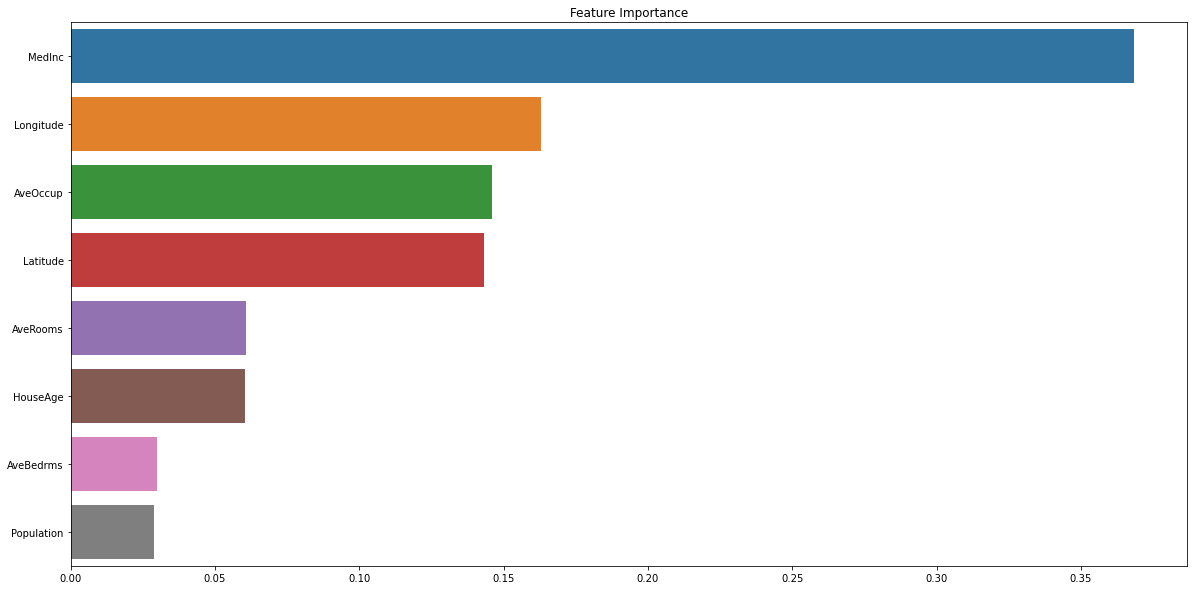

In [71]:
plot_feature_importances(model, train_X.columns, len(train_X.columns))